In [2]:
%%capture
import os
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import matplotlib as mpl
sns.set(font_scale=0.9, style='whitegrid', font='CMU Sans Serif')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (4.5,2)
mpl.rcParams['figure.dpi'] = 100
base_folder = "../../spcl/serverless-benchmarks/consistent-statistics"

df = pd.DataFrame()

for folder in glob(base_folder + "/*/"):
    base_split = folder.split("/")[-2].split("-")
    print(base_split)
    (provider, type, start_unix, end_unix) = base_split
    dfn = pd.read_csv(folder + "result.csv")
    dfn["provider"] = provider
    dfn["type"] = type
    dfn["start"] = pd.to_datetime(int(start_unix), unit="s")
    dfn["end"] = pd.to_datetime(int(end_unix), unit="s")
    dfn["hod"] = dfn["start"].dt.hour
    dfn["dow"] = dfn["start"].dt.day_of_week
    dfn["how"] = (dfn["dow"] * 24) + dfn["hod"]
    dfn["start_round_hour"] = dfn["start"].dt.round(freq="H")
    df = df.append(dfn)
df = df.set_index("start").sort_index()

def save_fig(ax, name, file_type="pdf"):
    fig = ax.get_figure()
    #fig.tight_layout()
    file_name = name + "." + file_type
    fig.savefig(os.path.join("graphs", file_name), bbox_inches='tight')

In [3]:
ah = df.loc[(df["provider"] == "aws")&(df["type"] == "html")&(df["is_cold"] == False)]
gh = df.loc[(df["provider"] == "gcp")&(df["type"] == "html")&(df["is_cold"] == False)]
gc = df.loc[(df["provider"] == "gcp")&(df["type"] == "zip")&(df["is_cold"] == False)]

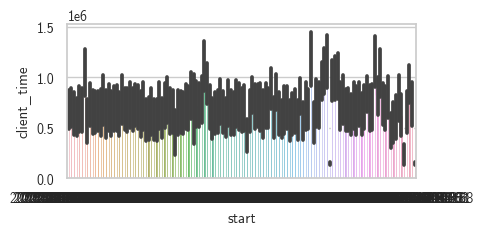

In [4]:
ax = sns.barplot(x=gh.index, y=gh["client_time"])

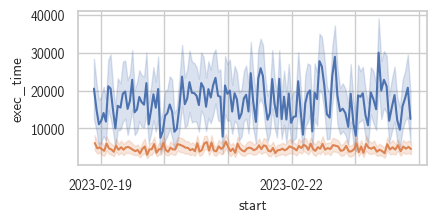

In [5]:
#sns.lineplot(x=gh["hod"], y=gh["exec_time"])
#sns.lineplot(x=ah["hod"], y=ah["exec_time"])
sns.lineplot(x=gh.index, y=gh["exec_time"])
sns.lineplot(x=ah.index, y=ah["exec_time"])

ax = plt.gca()
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 3 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

In [6]:
print(gh["exec_time"].std())
print(ah["exec_time"].std())

30028.323674802898
5708.234621481515


<Axes: xlabel='hod', ylabel='exec_time'>

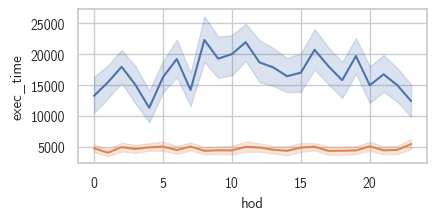

In [7]:
sns.lineplot(x=gh["hod"], y=gh["exec_time"])
sns.lineplot(x=ah["hod"], y=ah["exec_time"])

<Axes: xlabel='hod', ylabel='exec_time'>

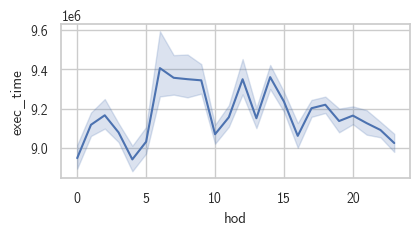

In [8]:
sns.lineplot(x=gc["hod"], y=gc["exec_time"])

<Axes: xlabel='start', ylabel='exec_time'>

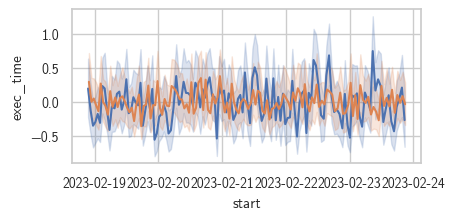

In [9]:
ghm = gh["exec_time"].mean()
ahm = ah["exec_time"].mean()
sns.lineplot(x=gh.index, y=(gh["exec_time"] - ghm)/ghm)
sns.lineplot(x=ah.index, y=(ah["exec_time"] - ahm)/ahm)

In [10]:
ahh = ah.resample("H").mean(numeric_only=True)
ahh["from"] = "aws"
ghh = gh.resample("H").mean(numeric_only=True)
ghh["from"] = "gcp"

In [11]:
ghhm = ghh["exec_time"].mean()
ahhm = ahh["exec_time"].mean()

print(ghhm)
print(ahhm)

16967.65721716225
4749.13593220339


/tmp/ipykernel_44274/1647263302.py:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['from'], dtype='object')
  sns.lineplot(x=ghh["hod"], y=(ghh.rolling("2h").mean()["exec_time"] - ghhm)/ghhm)
/tmp/ipykernel_44274/1647263302.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['from'], dtype='object')
  sns.lineplot(x=ahh["hod"], y=(ahh.rolling("2h").mean()["exec_time"] - ahhm)/ahhm)


<Axes: xlabel='hod', ylabel='exec_time'>

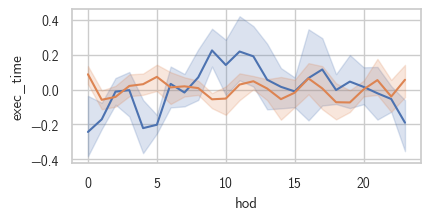

In [12]:

sns.lineplot(x=ghh["hod"], y=(ghh.rolling("2h").mean()["exec_time"] - ghhm)/ghhm)
sns.lineplot(x=ahh["hod"], y=(ahh.rolling("2h").mean()["exec_time"] - ahhm)/ahhm)

In [13]:
# Try to find the best case and worst case
mergedh = pd.merge(ahh, ghh, left_index=True, right_index=True, suffixes=("_aws", "_gcp"))

In [14]:
minDiff = (mergedh["exec_time_gcp"] - mergedh["exec_time_aws"]).min()
maxDiff = (mergedh["exec_time_gcp"] - mergedh["exec_time_aws"]).max()

minDiffDate = mergedh.loc[mergedh["exec_time_gcp"] - mergedh["exec_time_aws"] == minDiff].index
maxDiffDate = mergedh.loc[mergedh["exec_time_gcp"] - mergedh["exec_time_aws"] == maxDiff].index

print(f"Biggest Difference on {maxDiffDate} with aws {maxDiff} faster.")
print(f"On that day, google is ")
print(f"Smallest Difference on {minDiffDate} with aws {minDiff} faster.")

Biggest Difference on DatetimeIndex(['2023-02-23 08:00:00'], dtype='datetime64[ns]', name='start', freq='H') with aws 26160.925714285717 faster.
On that day, google is 
Smallest Difference on DatetimeIndex(['2023-02-23'], dtype='datetime64[ns]', name='start', freq='H') with aws 1989.5828571428574 faster.


/tmp/ipykernel_44274/3596298212.py:3: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['from_aws', 'from_gcp'], dtype='object')
  mergedroll = mergedh.rolling("4h").mean()


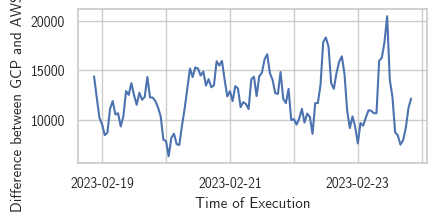

In [15]:
# Calculate Difference for Every Hour and Plot it
mergedh["exec_diff"] = mergedh["exec_time_gcp"] - mergedh["exec_time_aws"]
mergedroll = mergedh.rolling("4h").mean()
ax = sns.lineplot(mergedroll, y="exec_diff", x=mergedroll.index)
plt.ylabel("Difference between GCP and AWS [ms]")
plt.xlabel("Time of Execution")

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 2 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)


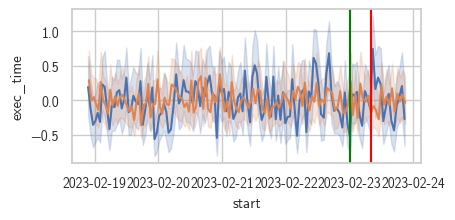

In [16]:
sns.lineplot(x=gh.index, y=(gh["exec_time"] - ghm)/ghm)
sns.lineplot(x=ah.index, y=(ah["exec_time"] - ahm)/ahm)
plt.axvline(maxDiffDate, color="Red")
plt.axvline(minDiffDate, color="Green")

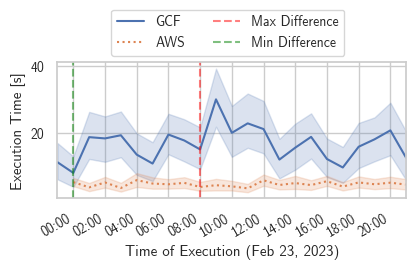

In [17]:
ghmonday = gh.loc[pd.to_datetime('2023-02-22 23:00:00'):pd.to_datetime('2023-02-24 00:00:00')]
ahmonday = ah.loc[pd.to_datetime('2023-02-22 23:00:00'):pd.to_datetime('2023-02-24 00:00:00')]
#ghmonday = mergedh.loc[pd.to_datetime('2023-02-22 23:00:00'):pd.to_datetime('2023-02-24 00:00:00')]
#ahmonday = mergedh.loc[pd.to_datetime('2023-02-22 23:00:00'):pd.to_datetime('2023-02-24 00:00:00')]
# 02-23

ax = sns.lineplot(x=ghmonday["start_round_hour"], y=ghmonday["exec_time"]/1000, label="GCF", linestyle="solid")
sns.lineplot(x=ahmonday["start_round_hour"], y=ahmonday["exec_time"]/1000, label="AWS", linestyle="dotted")

plt.axvline(maxDiffDate, color="Red", label="Max Difference", linestyle="dashed", alpha=0.5)
plt.axvline(minDiffDate, color="Green", label="Min Difference", linestyle="dashed", alpha=0.5)
#plt.text(maxDiffDate, 0.1, "Max Difference", rotation=90)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.legend(ncol=2, bbox_to_anchor=(0.135,1,1,0))
plt.xlabel("Time of Execution (Feb 23, 2023)")
plt.ylabel("Execution Time [s]")
plt.gcf().autofmt_xdate()
plt.autoscale(enable=True, axis='x', tight=True)
#save_fig(ax, "sebsChange")

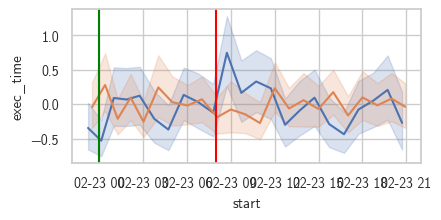

In [18]:
sns.lineplot(x=ghmonday.index, y=(ghmonday["exec_time"] - ghm)/ghm)
sns.lineplot(x=ahmonday.index, y=(ahmonday["exec_time"] - ahm)/ahm)
plt.axvline(maxDiffDate, color="Red")
plt.axvline(minDiffDate, color="Green")

Biggest Difference on DatetimeIndex(['2023-02-23 09:00:00'], dtype='datetime64[ns]', name='start_round_hour', freq=None) with aws 25631.025714285715 faster.
On that day, aws is percent faster: (gcf/aws) 6.871054024886435
Smallest Difference on DatetimeIndex(['2023-02-23'], dtype='datetime64[ns]', name='start_round_hour', freq=None) with aws 2754.862857142857 faster.
On that day, aws is percent faster: (gcf/aws) 1.520799529866241


TeX  NOT subset; don't know how to subset; dropped


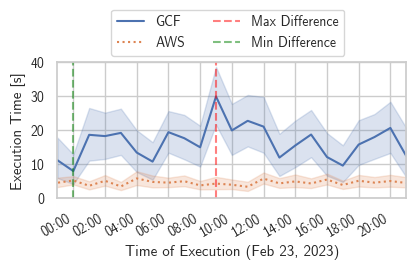

In [25]:
ahh = ah.groupby("start_round_hour").agg({"exec_time": "mean"})
ghh = gh.groupby("start_round_hour").agg({"exec_time": "mean"})
mergedh = pd.merge(ahh, ghh, left_index=True, right_index=True, suffixes=("_aws", "_gcp"))

minDiff = (mergedh["exec_time_gcp"] - mergedh["exec_time_aws"]).min()
maxDiff = (mergedh["exec_time_gcp"] - mergedh["exec_time_aws"]).max()

minDiffDate = mergedh.loc[mergedh["exec_time_gcp"] - mergedh["exec_time_aws"] == minDiff].index
maxDiffDate = mergedh.loc[mergedh["exec_time_gcp"] - mergedh["exec_time_aws"] == maxDiff].index

print(f"Biggest Difference on {maxDiffDate} with aws {maxDiff} faster.")
print(f"On that day, aws is percent faster: (gcf/aws)", mergedh.loc[maxDiffDate]["exec_time_gcp"].values[0]/mergedh.loc[maxDiffDate]["exec_time_aws"].values[0])
print(f"Smallest Difference on {minDiffDate} with aws {minDiff} faster.")
print(f"On that day, aws is percent faster: (gcf/aws)", mergedh.loc[minDiffDate]["exec_time_gcp"].values[0]/mergedh.loc[minDiffDate]["exec_time_aws"].values[0])

ghmonday = gh.loc[pd.to_datetime('2023-02-22 23:00:00'):pd.to_datetime('2023-02-24 00:00:00')]
ahmonday = ah.loc[pd.to_datetime('2023-02-22 22:00:00'):pd.to_datetime('2023-02-24 00:00:00')]
# 02-23

ax = sns.lineplot(x=ghmonday["start_round_hour"], y=ghmonday["exec_time"]/1000, label="GCF", linestyle="solid")
sns.lineplot(x=ahmonday["start_round_hour"], y=ahmonday["exec_time"]/1000, label="AWS", linestyle="dotted")

plt.axvline(maxDiffDate, color="Red", label="Max Difference", linestyle="dashed", alpha=0.5)
plt.axvline(minDiffDate, color="Green", label="Min Difference", linestyle="dashed", alpha=0.5)
#plt.text(maxDiffDate, 0.1, "Max Difference", rotation=90)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.legend(ncol=2, bbox_to_anchor=(0.135,1,1,0))
plt.xlabel("Time of Execution (Feb 23, 2023)")
plt.ylabel("Execution Time [s]")
plt.gcf().autofmt_xdate()
plt.gca().set_xlim([datetime(2023, 2, 22, 23,0,0), datetime(2023, 2, 23, 21,0,0)])
plt.ylim((0, 40))
#plt.autoscale(enable=True, axis='x', tight=True)
save_fig(ax, "sebsChange")

In [29]:
mergedh.loc[minDiffDate]["exec_time_gcp"].values[0]

8044.542857142857